# GMRES

## Algunos Ejemplos

In [1]:
import numpy as np
import scipy.linalg as spla
from scipy.sparse.linalg import gmres, LinearOperator
import matplotlib.pyplot as plt

### Error 

Para analizar convergencia.

In [2]:
error = lambda x, x_a: np.linalg.norm(x - x_a, ord=2, axis=1) / np.linalg.norm(x)
back_error = lambda x, A, b: np.linalg.norm(b - np.dot(A, x), ord=2) / np.linalg.norm(b)

Además, para graficar la convergencia.

In [3]:
def plot(err, b_e):
    Ni_e = np.arange(err.shape[-1])
    Ni_b = np.arange(b_e.shape[-1])
    plt.figure(figsize=(12, 6))
    plt.plot(Ni_e, err, 'bo', label=r'$||\mathbf{x} - \mathbf{x}_a||_2/||\mathbf{x}||_2$')
    plt.plot(Ni_b, b_e, 'rx', label=r'$||\mathbf{b} - A\,\mathbf{x}||_2/||\mathbf{b}||_2$')
    plt.yscale('log')
    plt.xlabel('# Iterations')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.show()

### Implementación $QR$ reducido

El algoritmo de Gram-Schmidt para obtener $\hat{Q}$ y $\hat{R}$.

In [4]:
def QR(A, modified=True):
    m, n = A.shape
    Q = np.zeros((m, n))
    R = np.zeros((n, n))
    # Gram-Schmidt orthogonalization
    for j in range(n):
        y = A[:, j]
        if modified:
            for i in range(j):
                R[i, j] = np.dot(Q[:, i], y)
                y = y - R[i, j] * Q[:, i]
        else:
            for i in range(j):
                R[i, j] = np.dot(Q[:, i], A[:, j])
                y = y - R[i, j] * Q[:, i]
        R[j, j] = np.linalg.norm(y)
        Q[:, j] = y / R[j, j]
    return Q, R

### Mínimos Cuadrados

- Utilizando $QR$
    1. Obtener $QR$ reducido, es decir, $A=\hat{Q}\,\hat{R}$
    2. Resolver $\hat{R}\,\hat{\mathbf{x}} = \hat{Q}^*\mathbf{b}$
    
    
- Utilizando Ecuaciones Normales
    1. Resolver $A^*A\hat{\mathbf{x}} = A^*\mathbf{b}$

In [5]:
def lstsq(A, b, qr=True):
    if qr:
        Q, R = QR(A) # QR reduced
        x = spla.solve_triangular(R, np.dot(Q.T, b)) # Solve Rx=Q^*b
    else:
        x = np.linalg.solve(np.dot(A.T, A), np.dot(A.T, b)) # Solve A^*Ax=A^*b
    return x

### Implementación GMRES

Versión modificada de [1].

In [6]:
def GMRES(A, b, x_0=None, tol=1e-10, max_iter=100, show=False, np_ls=False):
    m = b.shape[0]
    
    M = np.min([m, max_iter])
    
    X = np.zeros((M + 1, m))
    if x_0 is not None:
        X[0] = x_0
    
    r_0 = b - np.dot(A, X[0])
    n_r0 = np.linalg.norm(r_0)
    
    Q = np.zeros((m, m))
    H = np.zeros((m, m))
    
    Q[:, 0] = r_0 / n_r0

    for k in range(M):
        
        # Arnoldi Iteration
        y = np.dot(A, Q[:, k])
        for j in np.arange(k+1):
            H[j, k] = np.dot(Q[:,j], y)
            y = y - H[j, k] * Q[:,j]
        
        # Build H matrix and fill Q_k
        if k + 1 < m: 
            H[k+1, k] = np.linalg.norm(y)
            
            if np.abs(H[k+1, k]) > 1e-16:
                Q[:, k+1] = y / H[k+1, k]  

            e_1 = np.zeros((k + 1) + 1)        
            e_1[0] = 1
            H_tilde = H[:(k + 1) + 1, :k + 1]
            s = k + 1
        else: # When we use all Krylov subspace
            H_tilde = H[:k + 1, :k + 1]
            s = m + 1
            
        # Solving the 'SMALL' least squares problem. 
        if np_ls: 
            c_k, _, _, _ = np.linalg.lstsq(H_tilde, n_r0 * e_1, rcond=None) # Using Numpy Implementation (faster)
        else:
            c_k = lstsq(H_tilde, n_r0 * e_1) # Using algorithms seen in classes (slower)
        
        
        if show:
            print("k:", k)
            print("H:\n", H)
            print("H_t:\n", H_tilde)
            print("e_1:\n", e_1)
            print("c_k:\n", c_k)
            print("Q_k:\n", Q[:,:s])
            print()
            
        X[k+1] = X[0] + np.dot(Q[:, :s], c_k)  
        
        if np.linalg.norm(np.dot(A, X[k+1]) - b) < tol:
            X = X[:k + 2] 
            break
        
    return X

## Ejemplo 1

Matriz $A$ aleatoria.

In [7]:
np.random.seed(1234567890)
m = 50
A_1 = np.random.rand(m, m)
b_1 = np.dot(A_1, np.ones(m))

#### Solver de ```numpy```

In [8]:
x_1 = np.linalg.solve(A_1, b_1)
x_1

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### Implementación

In [9]:
x_g_1 = GMRES(A_1, b_1, tol=1e-10)
x_g_1[-1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### GMRES ```scipy```

In [10]:
x_s_1, _ = gmres(A_1, b_1)
x_s_1

array([1.19763667, 1.15258581, 0.75789253, 0.98707487, 1.10148399,
       0.92463966, 1.01559199, 1.13767641, 1.00459424, 1.17393247,
       0.90477812, 0.94783382, 0.98404039, 1.15778863, 0.94996579,
       0.98817646, 1.16153322, 0.94501359, 1.0144308 , 1.06213658,
       1.12572779, 0.92815843, 0.95481232, 0.83542311, 1.00947238,
       0.97835678, 0.95642767, 0.93572698, 0.9990528 , 1.08851003,
       0.78950694, 0.94941065, 0.79857037, 1.11264603, 1.13777757,
       0.97964287, 1.00943078, 1.00065634, 0.76325745, 1.04798721,
       1.21140939, 1.07522482, 0.83799066, 0.98403268, 1.08818604,
       1.01637778, 0.97685978, 0.87574449, 0.94158985, 0.9825196 ])

#### Convergencia

In [11]:
b_e_1 = np.array([back_error(x_i, A_1, b_1) for x_i in x_g_1])
err_1 = error(x_1, x_g_1)

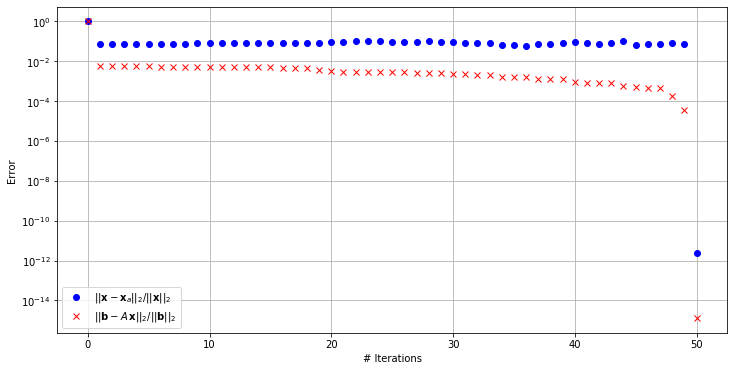

In [12]:
plot(err_1, b_e_1)

¿Podemos Mejorar la convergencia? Intentemos utilizando *GMRES* con reinicio.

In [13]:
p = 20
M = 5
X_r = np.zeros(((M * p), m))
x_0_ = None
for r in range(M):
    x_g_1_a = GMRES(A_1, b_1, x_0=x_0_, max_iter=p, tol=1e-16)
    X_r[r * p: (r + 1) * p] = x_g_1_a[1:]
    x_0_ = x_g_1_a[-1]

In [14]:
b_e_1_a = np.array([back_error(x_i, A_1, b_1) for x_i in X_r])
err_1_a = error(x_1, X_r)

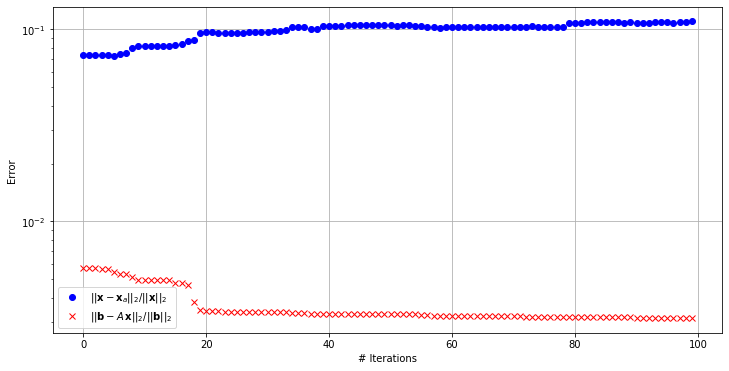

In [15]:
plot(err_1_a, b_e_1_a)

¿Problema? Quizás la matriz $A$ es mal condicionada.

In [16]:
np.linalg.cond(A_1)

1976.6502616108346

## Ejemplo 2

Modifiquemos levemente nuestra matriz $A$

In [17]:
A_2 = A_1 + m * np.eye(m) 
b_2 = np.dot(A_2, np.ones(m))

#### Solver de ```numpy```

In [18]:
x_2 = np.linalg.solve(A_2, b_2)
x_2

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### Implementación

In [19]:
x_g_2 = GMRES(A_2, b_2, tol=1e-10)
x_g_2[-1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### GMRES ```scipy```

In [20]:
x_s_2, _ = gmres(A_2, b_2)
x_s_2

array([1.00000283, 0.99999891, 0.99999816, 1.00000288, 0.99999952,
       1.00000131, 0.99999789, 0.99999908, 1.00000076, 0.9999992 ,
       0.99999774, 0.99999935, 1.00000072, 0.99999843, 0.99999799,
       0.99999967, 1.00000151, 0.99999965, 1.00000197, 0.99999941,
       1.00000173, 1.00000211, 1.00000044, 1.00000144, 0.99999903,
       0.99999915, 0.99999907, 1.0000025 , 1.0000014 , 0.99999941,
       0.99999976, 1.00000038, 0.99999592, 0.99999985, 1.00000254,
       1.00000003, 0.99999703, 0.99999811, 1.00000046, 0.99999981,
       0.99999927, 0.99999954, 0.99999972, 1.00000031, 1.00000321,
       1.00000122, 0.99999899, 1.00000174, 0.99999856, 1.00000003])

In [21]:
b_e_2 = np.array([back_error(x_i, A_2, b_2) for x_i in x_g_2])
err_2 = error(x_2, x_g_2)

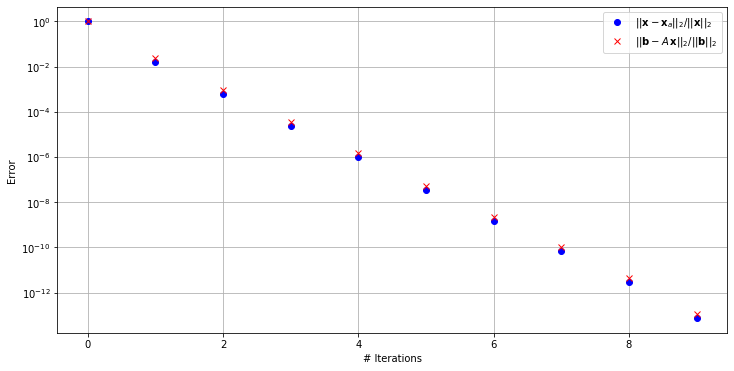

In [22]:
plot(b_e_2, err_2)

## Ejemplo 3: Evitar construir $A$ explícitamente

Supongamos necesitamos resolver el sistema $A\mathbf{x}=\mathbf{b}$, con $A\in\mathbb{R}^{n\times n}$ tridiagonal, y $\mathbf{b}\in\mathbb{R}^n$. ¿Necesitamos calcular el producto matriz vector $A\mathbf{v}$ para $\mathbf{v}\in\mathbb{R}^n$ cualquiera?

La estructura de $A$ tridiagonal es:
\begin{equation}
    A=
    \begin{bmatrix}
        a_{1} & b_{1}\\
        c_{1}& a_{2} & b_{2}\\
        &c_{2}&\ddots &\ddots \\
        & & \ddots & \ddots &b_{n-1}\\
        & & & c_{n-1} & a_{n}
    \end{bmatrix}
\end{equation}

### Construcción $A$ tridiagonal

In [23]:
def buildA(n):
    np.random.seed(1234)
    # Random arrays to fill diagonals
    a_ = np.random.rand(n)
    b_ = np.random.rand(n-1)
    c_ = np.random.rand(n-1)
    # Temporal matrices to add diagonals
    a_tmp = np.zeros((n, n))
    b_tmp = np.zeros_like(a_tmp)
    c_tmp = np.zeros_like(a_tmp)
    # Diagonals
    a_tmp = a_ * np.eye(n) # Main diagonal
    b_tmp[:-1,1:] = b_ * np.eye(n-1) # Above diagonal
    c_tmp[1:,:-1] = c_ * np.eye(n-1) # Below diagonal 

    # Build A
    A = a_tmp + b_tmp + c_tmp
    
    del a_tmp, b_tmp, c_tmp
    
    return A

In [24]:
n = 5
A = buildA(n)

In [25]:
# Just show when A is small...
if n < 7:
    print(A)

[[0.19151945 0.27259261 0.         0.         0.        ]
 [0.87593263 0.62210877 0.27646426 0.         0.        ]
 [0.         0.35781727 0.43772774 0.80187218 0.        ]
 [0.         0.         0.50099513 0.78535858 0.95813935]
 [0.         0.         0.         0.68346294 0.77997581]]


### Construcción ```afun(v)```

Con esta función queremos calcular el producto matriz vector $A\mathbf{v}$ sin necesidad de ocupar todos los coeficientes de $A$. Dado que la matriz tiene muchas entradas nulas evitamos aplicar el algoritmo completo de multiplicación matriz-vector.

In [26]:
def buildAfun(A, v):
    # Get matrix diagonals
    a = np.diag(A)
    b = np.diag(A, 1)
    c = np.diag(A, -1)
    
    # Vector size
    n = v.shape[0]
    u = np.zeros(n) # Output vector
    
    u[0] = a[0] * v[0] + b[0] * v[1] # First element of u
    u[-1] = c[-1] * v[-2] + a[-1] * v[-1] # Last element of u
    for i in range(1, n-1):
        u[i] = c[i-1] * v[i-1] + a[i] * v[i] + b[i] * v[i+1] # Inside u...
    return u

Probemos el tiempo de cómputo multiplicando por un vector aleatorio.

In [27]:
n_test = 10000 # For large n we can see the difference in computational time
A_test = buildA(n_test)
v = np.random.rand(n_test)
afun_test = lambda v: buildAfun(A_test, v)

In [28]:
%timeit np.dot(A_test, v)

52 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%timeit afun_test(v)

22.1 ms ± 688 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
Av_1 = np.dot(A_test, v)
Av_2 = afun_test(v)
print(np.linalg.norm(Av_1- Av_2))

4.8266229755959866e-15


Notamos que calcular el producto punto es mucho más costoso que utilizar nuestra función. Luego vemos que el resultado de ambos $A\mathbf{v}$ es similar. Importante que la diferencia de tiempo computacional se aprecia para valores de $n$ grandes, ya que ```numpy``` ya tiene considerablemente optimizado el producto matriz-vector.

### "Matrix-free" GMRES

Modificamos nuestro algoritmo para que no calcule el producto matriz-vector y utilizamos nuestra ```afun(v)```.

In [31]:
def GMRES2(fun, b, x_0=None, tol=1e-10, max_iter=100, show=False, np_ls=False):
    m = b.shape[0]
    M = np.min([m, max_iter])
    X = np.zeros((M + 1, m))
    if x_0 is not None:
        X[0] = x_0
    
    r_0 = b - fun(X[0])
    n_r0 = np.linalg.norm(r_0)
    Q = np.zeros((m, m))
    H = np.zeros((m, m))
    Q[:, 0] = r_0 / n_r0

    for k in range(M):
        
        # Arnoldi Iteration
        y = fun(Q[:, k])
        for j in np.arange(k+1):
            H[j, k] = np.dot(Q[:,j], y)
            y = y - H[j, k] * Q[:,j]
        
        # Build H matrix and fill Q_k
        if k + 1 < m: 
            H[k+1, k] = np.linalg.norm(y)
            
            if np.abs(H[k+1, k]) > 1e-16:
                Q[:, k+1] = y / H[k+1, k]  

            e_1 = np.zeros((k + 1) + 1)        
            e_1[0] = 1
            H_tilde = H[:(k + 1) + 1, :k + 1]
            s = k + 1
        else: # When we use all Krylov subspace
            H_tilde = H[:k + 1, :k + 1]
            s = m + 1
            
        # Solving the 'SMALL' least squares problem. 
        if np_ls: 
            c_k, _, _, _ = np.linalg.lstsq(H_tilde, n_r0 * e_1, rcond=None) # Using Numpy Implementation
        else:
            c_k = lstsq(H_tilde, n_r0 * e_1) # Using algorithms seen in classes
        
        
        if show:
            print("k:", k)
            print("H:\n", H)
            print("H_t:\n", H_tilde)
            print("e_1:\n", e_1)
            print("c_k:\n", c_k)
            print("Q_k:\n", Q[:,:s])
            print()
            
        X[k+1] = X[0] + np.dot(Q[:, :s], c_k)  
        
        if np.linalg.norm(fun(X[k+1]) - b) < tol:
            X = X[:k + 2] 
            break
        
    return X

In [32]:
n = 100
A_3 = buildA(n)
b_3 = np.dot(A_3, np.arange(1, n+1))
afun = lambda v: buildAfun(A_3, v)

In [33]:
x_3 = GMRES(A_3, b_3, np_ls=True, max_iter=n)

In [34]:
x_3[-1]

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100.])

In [35]:
x_3 = GMRES2(afun, b_3, np_ls=True, max_iter=n)

In [36]:
x_3[-1]

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100.])

Notar que en ambos casos obtenemos la solución, pero el impacto de ```afun(v)``` se ve cuando tenemos sistemas de ecuaciones muy grandes.

## Comentarios

Recordar que en cada iteración la complejidad de nuestro algoritmo es la complejidad del producto matriz-vector $O(m^2)$ más la resolución del problema de mínimos cuadrados $O(k^3)$ si utilizamos $QR$ por ejemplo. Se omite la obtención de $h_{j,k}$ ya que es un producto punto, es decir, $O(m)$. De acuerdo a [3] podemos reducir la complejidad del problema de mínimos cuadrados aprovechando la estructura de $\tilde{H}_k$ de manera que la mayor parte del costo computacional se encuentra en resolver $\hat{R}\,\mathbf{x}=\hat{Q}^*\mathbf{b}$, que sería $O(k^2)$. 

Ahora, nuestro algoritmo tiene como complejidad $k\left(O(m^2) + O(k^2)\right)$, donde el peor caso es $k=m$, o sea obtenemos una complejidad de $O(m^3)$ similar a $PA=LU$ por ejemplo. El objetivo es resolver el problema cuando $k<m$, es decir, con complejidad $O(k^3)$. Notar que el uso de ```afun(v)``` nos ayuda a evitar el costo de la multiplicación matriz-vector.

---

## Ejercicio 4: Ecuación de Sylvester

La ecuación de Sylvester es una ecuación matricial de la forma:
\begin{equation}
    A\,X + X\,B = C,
\end{equation}

donde $A, B, C \in \mathbb{R}^{n \times n}$ son matrices conocidas y $X\in \mathbb{R}^{n \times n}$ nuestra matriz incógnita. 

Utilicemos un método iterativo para resolverlo. Algoritmo obtenido de [4].

### Idea 1
\begin{equation}
    \begin{split}
        A\,X + X\,B & = C \\
        A\,X & = C - X\,B 
    \end{split}
\end{equation}

Luego iteramos $A\,X_{i+1} = C - X_i\,B$, con $X_0$ una estimación inicial.

### Idea 2
\begin{equation}
    \begin{split}
        A\,X + X\,B & = C \\
        X\,B & = C - A\,X \\
        (X\,B)^T & = (C - A\,X)^T  \\
        B^TX^T &= (C - A\,X)^T 
    \end{split}
\end{equation}

Luego iteramos $B^T\,X^T_{i+1} = (C - A\,X_i)^T$, con $X_0$ una estimación inicial.

In [37]:
np.random.seed(2468)
n = 10
A_4 = np.random.rand(n, n) + n * np.eye(n)
B_4 = np.random.rand(n, n)
C_4 = np.random.rand(n, n)

In [38]:
def iterativeSylvester(A, B, C, m, alg=1, tol=1e-10):
    X0 = np.zeros_like(A)
    X1 = np.zeros_like(A)
    if alg == 1: # Algorithm 1
        for i in range(m):
            X1 = np.linalg.solve(A, C - np.dot(X0, B))
            X0 = X1
            if np.linalg.norm(np.dot(A, X1) + np.dot(X1, B) - C) < tol:
                break
        return X1
    elif alg == 2: # Algorithm 2
        for i in range(m):
            X1 = np.linalg.solve(B.T, (C - np.dot(A, X0)).T).T
            X0 = X1
            if np.linalg.norm(np.dot(A, X1) + np.dot(X1, B) - C) < tol:
                break
        return X1

### Propuesta 1

In [39]:
X_1 = iterativeSylvester(A_4, B_4, C_4, 70)

In [40]:
np.linalg.norm(np.dot(A_4, X_1) + np.dot(X_1, B_4) - C_4)

6.53279812709292e-11

### Propuesta 2

In [41]:
X_2 = iterativeSylvester(A_4, B_4, C_4, 10, 2)

In [42]:
np.linalg.norm(np.dot(A_4, X_2) + np.dot(X_2, B_4) - C_4)

2.5849271783041154e+22

### Propuesta 3

Utilizando GMRES. En este enfoque, vectorizamos la matriz $C$ para resolver un problema $A\,\mathbf{x}=\mathbf{b}$ donde $\mathbf{b}=\operatorname{vec}(C)$. Además, nuestro "producto matriz vector", será $AX+XB$. 

In [43]:
def AXBX(x, A, B):
    X = np.reshape(x, A.shape) # Get flattened version of x and reshape to get X
    out = np.dot(A, X) + np.dot(X, B) # Out "matrix-vector" multiplication
    return out.flatten()

Ax = lambda x: AXBX(x, A_4, B_4)

#### Resolviendo con GMRES implementado

In [44]:
x_u = GMRES2(Ax, C_4.flatten(), np_ls=True, max_iter=n ** 2) # C.flatten() is vec(C)...
X_3_u = np.reshape(x_u[-1], A_4.shape)

In [45]:
np.linalg.norm(np.dot(A_4, X_3_u) + np.dot(X_3_u, B_4) - C_4)

2.626608384452874e-11

#### Resolviendo con GMRES de ```scipy```

In [46]:
# This is required by Scipy GMRES... It's just a funcion to compute matrix-vector multiplication
afun2 = LinearOperator((n ** 2, n ** 2), matvec = Ax) 
x_s, exitCode = gmres(afun2, C_4.flatten(), tol=1e-10)
X_3_s = np.reshape(x_s, A_4.shape)

In [47]:
np.linalg.norm(np.dot(A_4, X_3_s) + np.dot(X_3_s, B_4) - C_4)

1.6638877930818026e-10

### Solución del problema

In [48]:
X = spla.solve_sylvester(A_4, B_4, C_4)

In [49]:
print("Propuesta 1: ", np.linalg.norm(X_1 - X))
print("Propuesta 2: ", np.linalg.norm(X_2 - X)) 
print("Propuesta 3a:", np.linalg.norm(X_3_s - X))
print("Propuesta 3b:", np.linalg.norm(X_3_u - X))

Propuesta 1:  4.689803856203944e-12
Propuesta 2:  1.690995795460254e+21
Propuesta 3a: 1.6368741557609354e-11
Propuesta 3b: 2.5798177172434354e-12


La propuesta 2 no converge. 
El objetivo del ejercicio es conectar una iteración de punto fijo con una ecuación matricial.

# Referencias
* [1] https://github.com/tclaudioe/Scientific-Computing/blob/master/SC1/10_GMRes.ipynb
* [2] https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.gmres.html
* [3] Trefethen, L. N., & Bau III, D. (1997). Numerical linear algebra (Vol. 50). SIAM.
* [4] https://github.com/tclaudioe/Scientific-Computing/blob/master/SC1/Bonus%20-%20Sylvester%20Equation%20with%20GMRes%20.ipynb